# CSII 2023 Exercise 02: State Feedback for Duckiebot Steering

Reference: 
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019

## State Feedback for Duckiebot Steering
The dynamics of the Duckiebot are given by a simple unicycle model, which is similar to the Duckiebot model presented in the first lecture. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the Duckiebot in the plane and $\theta$ is the angle of the Duckiebot with respect to the x-axis. The input of the Duckiebot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$. 

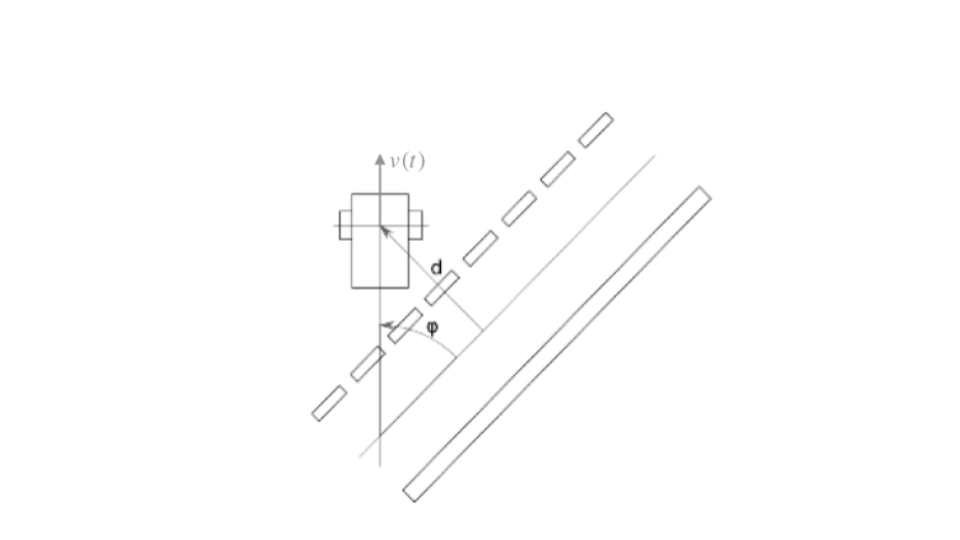

-------
## Installation 
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search. 





In [1]:
# Install the required python library with pip 
%pip install control

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.



In [2]:
# Import the required python libraries
from typing import Optional, List
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the Duckiebot are defined in the next cell.

In [3]:
def unicycle_update(t: float, x: np.array, u: np.array, params: dict):
    # Return the derivative of the state
    max_omega = params.get('max_omega', 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v sin(theta)
        omega     # thdot = w
    ])

def unicycle_output(t: float, x: np.array, u: np.array, params: dict):
    return x[0:2]

## Plotting
The next cell implements some plotting functions using the [Matplotlib](https://matplotlib.org/) library. If you are interested, take a look.

In [5]:
#@title
def plot_track(x_coord_ref: np.array, y_coord_ref: np.array, 
               theta_ref: np.array, t: np.array, 
               w_curvy: np.array, 
               y_ctr: Optional[np.array] = None,
               w_ctr: Optional[np.array] = None) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])
    # Plot the resulting trajectory (and some road boundaries)
    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    if y_ctr is not None:
        plt.plot(y_ctr, x_coord_ref, 'r', linewidth=1)
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    
    
    
    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)
    if y_ctr is not None:
        plt.plot(t_curvy, y_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    if w_ctr is not None:
        plt.plot(t_curvy, w_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()


def plot_track_multiple_controller(x_coord_ref: np.array, y_coord_ref: np.array, 
               theta_ref: np.array, t: List[np.array], 
               w_curvy: np.array, 
               y_ctr: List[np.array],
               w_ctr: Optional[np.array]) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    number_ctr = len(t)
    plt.figure(figsize=[14, 6])
    # Plot the resulting trajectory (and some road boundaries)

    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(y_ctr[i], x_coord_ref, linewidth=1)
        legend_list.append(f'controller_{i}')
    
    plt.legend(legend_list, loc='upper left')
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    
    
    
    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t[0], y_coord_ref)
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(t[i], y_ctr[i], linewidth=1)
        legend_list.append(f'controller_{i}')
    plt.legend(legend_list)
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t[0], w_curvy)
    for i in range(number_ctr):
        plt.plot(t[i], w_ctr[i], linewidth=1)
        legend_list.append(f'controller_{i}')
    plt.legend(legend_list)
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()

# Utility function to plot the step response
def plot_step_response(t: np.array, y: np.array, u: np.array):
    axes_out = plt.subplot(2, 1, 1)
    plt.sca(axes_out)
    plt.plot(t, y)
    plt.ylabel('Lateral position $y$ in [m]')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')
    
    axes_input = plt.subplot(2, 1, 2)
    plt.sca(axes_input)
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\omega$ [rad/s]')
    plt.plot(t, u[0])

def plot_sim_results(y_ref: np.array, y: np.array, 
                     theta_ref: np.array, theta: np.array,
                     t: np.array, w_ref: np.array,
                     w: np.array) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[15, 4.5])

    # Plot the actual and estimated states
    ax = plt.subplot(1, 2, 1)
    plt.plot(t, y)
    plt.plot(t, y_ref, 'k-.')
    ax.set(xlim=[0, 30])
    plt.legend(['state feedback', 'y', 'reference'])
    plt.xlabel('Time t [sec]')
    plt.ylabel('Lateral position $y$ [m]')

    ax = plt.subplot(2, 2, 2)
    plt.plot(t, theta)
    # plt.plot(t, x[3])
    plt.plot(t, theta_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.ylabel('Angle $\\theta$ [rad]')

    ax = plt.subplot(2, 2, 4)
    plt.plot(t, w)
    # plt.plot(t, u_ofb[0])
    plt.plot(t, w_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\\omega$ [rad/s]')


## Parameters and Reference Track

We set a default Duckiebot velocity and generate the nonlinear system using the `control` library. 

In [7]:
# Default Duckiebot velocity in m/s
duckie_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the Duckiebot's steering dynamics as an input/output system
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name='duckiebot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=duckie_params)

v0 = duckie_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

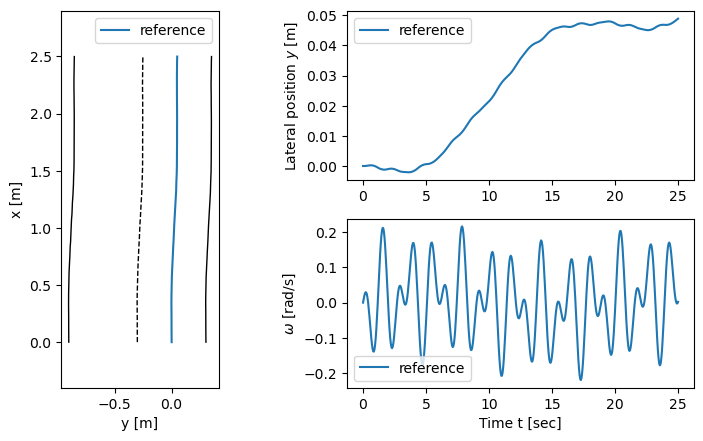

In [15]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'straight']
curve_difficulty = curve_difficulty_levels[1]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = np.zeros(T_curvy.shape)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [17]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C

Linearized system dynamics:

<LinearIOSystem>: sys[3]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0.  0.1]
     [0.  0. ]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



------

## Exercise 1: Reachability
Write code to check if the linearized and normalized system is reachable. Use only the `numpy` library. 

**NumPy Hints**: 
*   matrix multiplication: `Z = X @ Y`
*   rank of a matrix: `r = np.linalg.matrix_rank(X)`
*   concatination of matrices along column axis: `XY = np.concatenate((X, Y), axis=1)`




In [ ]:
# Write here the reachability test

## Solution Exercise 1: Reachability

In [19]:
#@title
AB = A @ B
R = np.concatenate((B, AB), axis=1)
r = np.linalg.matrix_rank(R)

if r < 2:
  print(f'The system is not reachable because the rank of R is: {r}.')
else:
  print(f'The system is reachable because rank of R is: {r}.')

The system is reachable because rank of R is: 2.


--------------

## Exercise 2: Ackermann's formula
Now we want to use the Ackermann'*s* formula to get our closed loop gain. With the `control` library this is very easy. Just use: `K = ct.acker(A,B,poles)`. Try to implement your own version using the A and B matrices and a list of poles you want. Try to use only the `numpy` library. 

**NumPy Hints**: 
*   matrix inverse: `np.linalg.inv(X)`
*   2x2 identity matrix: `np.identity(2)`

In [ ]:
def acker(A: np.array, B: np.array, poles: List[float]) -> np.array:
    # TODO: write code
    K = np.array([[1, 1]])

    return K

Test your implemenation against the implementation from the `control` library.

In [18]:
poles = [-1, -1]

K_a = acker(A=A, B=B, poles=poles)

K_c = ct.acker(A,B,poles)

print(f'Your K: {K_a} and the control K: {K_c}.')


NameError: name 'acker' is not defined

### Solution Exercise 2: Ackermann's formula

In [ ]:
#@title
def acker_solution(A: np.array, B: np.array, poles: List[float]) -> np.array:
    AB = A @ B
    R = np.concatenate((B, AB), axis=1)
    R_inv = np.linalg.inv(R)
    gamma = np.array([[0, 1]]) @ R_inv
    
    p_1 = poles[0]*(-1)
    p_2 = poles[1]*(-1)
    ab = p_1 + p_2
    b = p_1*p_2
    p_cl = A @ A + ab*A + b*np.identity(2)
    
    K = gamma @ p_cl

    return K

--------------

## Exercise 3: Feedforward gain
Try to implement the calculation of the feedforward gain $k_r$ such that the steady state error is $y_{ss}=r$. 

In [ ]:
def feedforward_kr(A: np.array, B: np.array, C: np.array, K: np.array) -> np.array:
    # TODO: write code
    kr = 1

    return kr

### Solution Exercise 3: Feedforward gain

In [ ]:
#@title
def feedforward_kr_solution(A: np.array, B: np.array, C: np.array, K: np.array) -> np.array:
    ABK = A - B @ K
    ABK_inv = np.linalg.inv(ABK)
    den = C @ ABK_inv @ B
    kr = - 1/den

    return kr

-----------------

## Pole Placement

We compute the gains by using either the Ackermann's formula from `control`, the solution of the Exercise 2 or your implementation. 



In [ ]:
def place_poles_Ackermann(A: np.array, B: np.array, C: np.array, 
                          D: float, poles: List, version: str = 'control'):
    if version == 'control':
      K = ct.acker(A,B,poles)
    elif version == 'solution':
      K = acker_solution(A,B,poles)
    elif version == 'exercise':
      K = acker(A,B,poles)
    else:
      raise ValueError("Invalid version")

    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, C, D)
    
    if version == 'exercise':
      kr = feedforward_kr(A, B, C, K)
    else:
      kr = feedforward_kr_solution(A, B, C, K)

    # Scale the input by the feedforward gain
    clsys *= kr

    # Return gains and closed loop system dynamics
    return K, kr, clsys

In the next cell we define our desired poles. Change them if you want. Then in `place_poles_Ackermann(A=A, B=B, C=C, D=0, poles=poles, version='control')` we calculate the gains of the closed loop system. Set `version='control'` if you want to see the gains calculated by `control`, set `version='solution'` to test the solution implementation and `version='exercise'` to test your implementation.

In [ ]:
# Place the poles of the system
poles = [-1, -1]

K, kr, clsys = place_poles_Ackermann(A=A, B=B, C=C, D=0, 
                                     poles=poles, version='control')

# Print out the gains
print("K = ", K)
print("kr = ", kr)

K =  [[10.  2.]]
kr =  [[10.]]


## Step Response

First, we test our state feedback controller with a step response.

In [ ]:
# Compute the step response
t, y, x = ct.step_response(clsys, np.linspace(0, 20, 100), return_x=True)

In [ ]:
# Compute the input used to generate the control response (check lecture slides)
u = -K @ x + kr * 1

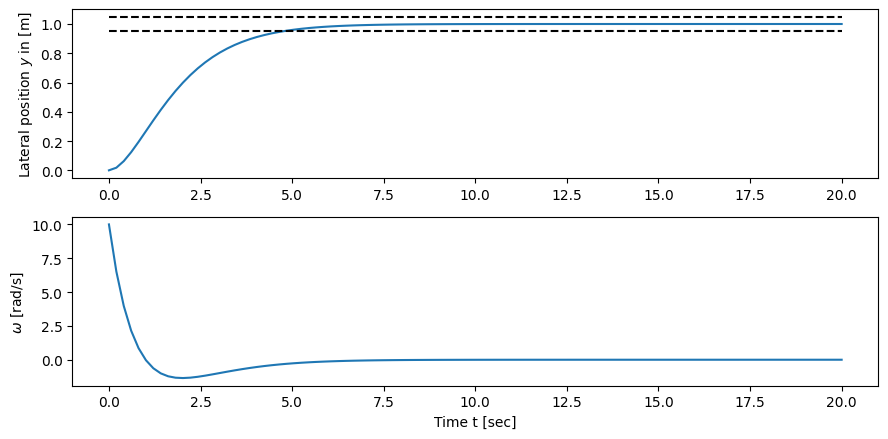

In [ ]:
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
plot_step_response(t, y, u)
plt.tight_layout()

## Simulation

Finally, we simulate the system to test how the controller performs against our previously defined reference.

In [ ]:
x_ref = x_curvy[0]
y_ref = x_curvy[1]
theta_ref = x_curvy[2]
# Simulate the system
t, y, x = ct.forced_response(clsys, T_curvy, y_ref, [0.2, 0.0], return_x=True)

In [ ]:
# Calcaluate the input used to generate the control response (check lecture slides)
u_sfb = kr * y_ref - K @ x

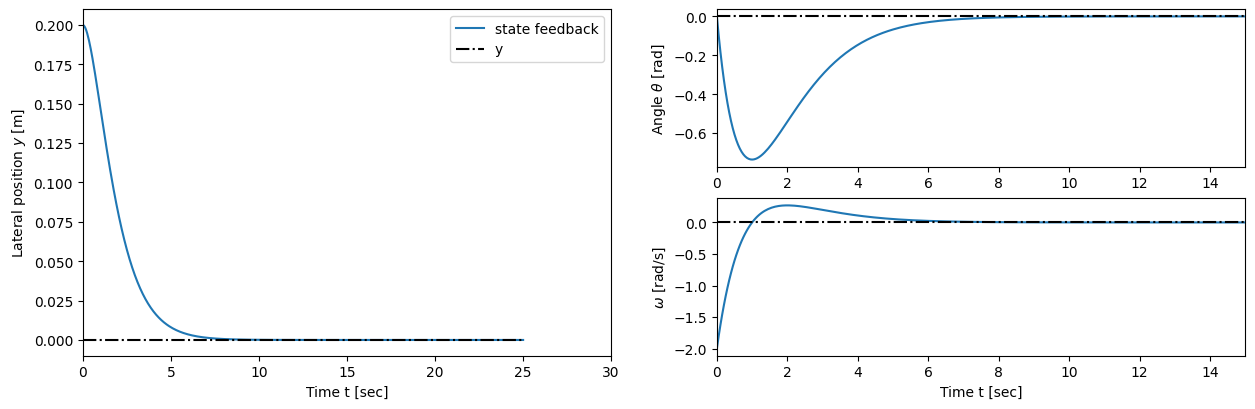

In [ ]:
y_ctr = y
plot_sim_results(y_ref=x_curvy[1], y=y_ctr, theta_ref=theta_ref, theta=x[1], t=t, 
                            w_ref=w_curvy, w=u_sfb[0])

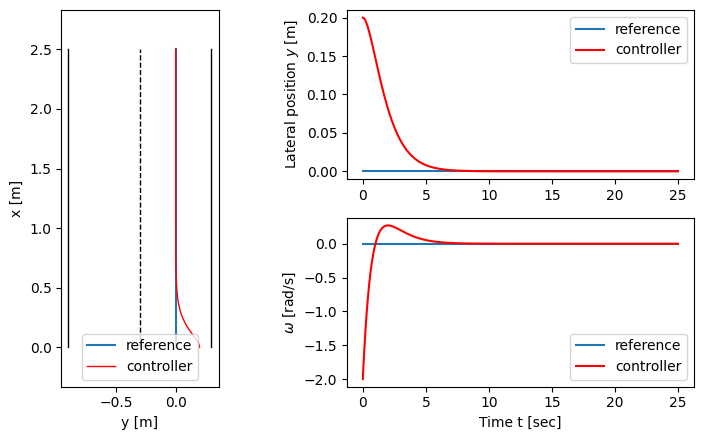

In [ ]:
plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy, 
            y_ctr, u_sfb[0])

## Poles Comparison

In this section we will do the same as before, just comparing different poles against each other. We will compare aggressive poles, less aggressive poles and complex conjugate poles.

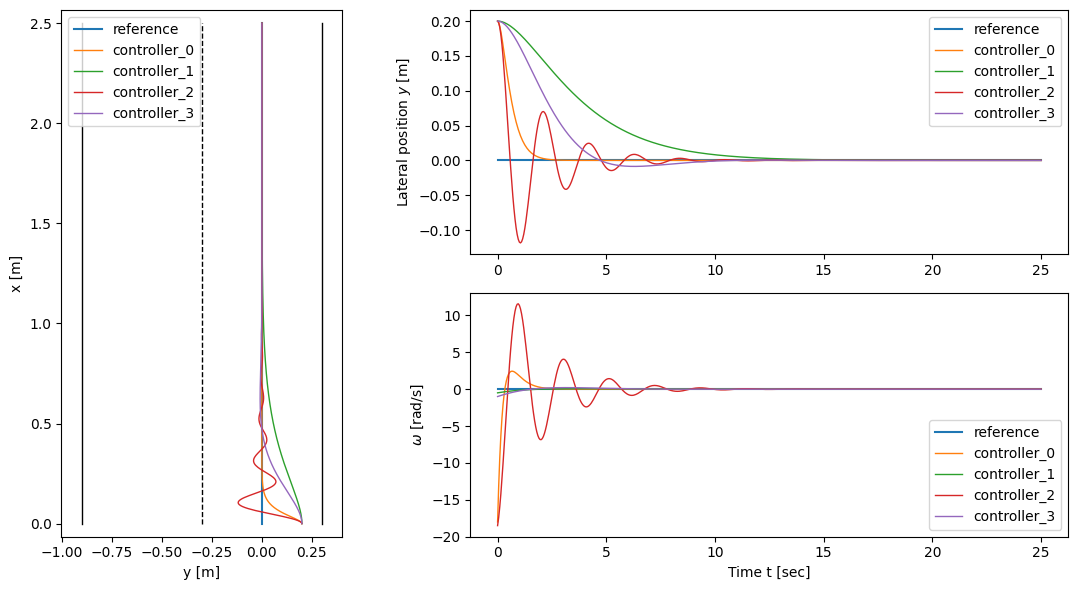

In [ ]:
poles_aggressive = [-3, -3]
poles_easy = [-0.5, -0.5]
poles_complex_1 = [-0.5+3j, -0.5-3j]
poles_complex_2 = [-0.5+0.5j, -0.5-0.5j]

pole_list = [poles_aggressive, poles_easy, poles_complex_1, poles_complex_2]
t_list = []
y_list = []
u_list = []
for p in pole_list:
  K_p, kr_p, clsys_p = place_poles_Ackermann(A=A, B=B, C=C, D=0, 
                                     poles=p, version='control')
  t_p, y_p, x_p = ct.forced_response(clsys_p, T_curvy, y_ref, [0.2, 0.0], return_x=True)
  t_list.append(t_p)
  y_list.append(y_p)
  u_sfb_p = kr_p * y_ref - K_p @ x_p
  u_list.append(u_sfb_p[0])

plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list, 
                               w_curvy, y_list, u_list)


## Outlook
- Change the tracks and create your own reference track
- Use different poles and check how the controller performance changes
- Ask ChatGPT for solutions and compare them with your own :) 